In [35]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [36]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [37]:
ab = '../'+expand(config['data']['ab'], species='human')[0]
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
read_annot = '../'+expand(config['data']['read_annot'], species='human')[0]
t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]
cerb_t_metadata = '../'+expand(config['data']['t_info'], species='human')[0]
major_isos = '../'+expand(config['data']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = '../'+expand(config['data']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]
ref_t_metadata = '../'+expand(config['ref']['t_info'], species='human')[0]
ref_g_metadata = '../'+expand(config['ref']['g_info'], species='human')[0]

introp_bed = '../'+expand(config['intropolis']['bed'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = '../'+expand(config['data']['meta'], species='mouse')[0]

In [38]:
def get_source_table(df):
    """
    Get a melted form table for each entry in a tss, ic, or tes table
    for each form of support for each triplet feature.
    
    Parameters:
        df (pandas DataFrame): DataFrame of tsss, ics, or tess
    
    Returns:
        df (pandas DataFrame): Long-form DataFrame of support for each tss, ic, or tes
    """
    keep_cols = ['Name', 'source']
    df = ic[keep_cols].copy(deep=True)
    df['list_source'] = df.source.str.split(',')
    df = df.explode('list_source')
    df.drop('source', axis=1, inplace=True)
    
    return df

# chatgpt wrote this for me thanx chatgpt
def sequential_pairs(x):
    """
    Get sequential pairs of tuples in list.
    Example: [1,2,3,4] -> [(1,2),(3,4)]
    """
    p = []
    for i in range(0, len(x) - 1, 2):
        p.append((x[i], x[i + 1]))
    return p

def explode_ic(ic):
    """
    Explode an ic df to long form with splice junction entries
    """
    # remove the monoexonic entries
    ic = ic.loc[~(ic.Coordinates == '-')]
    
    # explode into series of ss coords
    keep_cols = ['Chromosome', 'Coordinates',
                 'Strand', 'gene_id',
                 'Name']
    df = ic.copy(deep=True)
    df = df[keep_cols]
    df['ss_coords'] = df.Coordinates.str.split('-')
    
    # get pairs of sss to form sjs
    df['sj_coords'] = df.ss_coords.apply(sequential_pairs)
    df = df.explode('sj_coords')
    df.drop(['Coordinates', 'ss_coords'], axis=1, inplace=True)
                
    return df

def get_ss_sj_from_ic(ic, ref_sources, how):
    ic = ic.copy(deep=True)

    # get coords of each splice site in each splice junction
    df = explode_ic(ic)
    df['Start'] = df['sj_coords'].str[0].astype(int)
    df['End'] = df['sj_coords'].str[1].astype(int)
    df.drop('sj_coords', axis=1, inplace=True)

    # label sss as 5' or 3' and melt
    if how == 'ss':
        assert len(df.loc[(df.Start>df.End)&(df.Strand=='+')].index) == 0
        # since these are intron coords, the start defines a 3' ss 
        # and the end defines a 5' ss
        df.rename({'Start':'ss_3', 'End':'ss_5'}, axis=1, inplace=True)
        id_cols = ['Chromosome', 'Strand', 'gene_id', 'Name']
        df = df.melt(id_vars=id_cols,
                     var_name='ss_type',
                     value_name='Start')
        
    # for sjs, reorder according to min and max coords
    # in bed standard format
    elif how == 'sj':
        df['temp_Start'] = df.Start
        df['temp_End'] = df.End
        df['Start'] = df[['temp_Start', 'temp_End']].min(axis=1)
        df['End'] = df[['temp_Start', 'temp_End']].max(axis=1)
        df.drop(['temp_Start', 'temp_End'], axis=1, inplace=True)
             
    # df to hold ic to ss or sj info 
    ic_df = df.copy(deep=True)
    
    # merge source info in w/ coord info
    df2 = get_source_table(ic)
    df = df.merge(df2, how='left', on=['Name'])
    
    # figure out novelty and source of each ss / sj
    df.drop('Name', axis=1, inplace=True)
    df.drop_duplicates(inplace=True)
    gb_cols = ['Chromosome', 'Strand', 'gene_id', 'Start']
    if how == 'ss':
        gb_cols += ['ss_type']
    elif how == 'sj':
        gb_cols += ['End']
    df.rename({'list_source': 'source'},
              axis=1, inplace=True)
    df['novelty'] = df.source.isin(ref_sources).map({True: 'Known',
                                                     False: 'Novel'})
    df = df.groupby(gb_cols).agg(','.join).reset_index()
    df = cerberus.update_novelty(df)
    
    # add novelty and support information to the ic / (ss or sj) df
    ic_df = ic_df.merge(df, how='left',
                        on=['Chromosome', 'Start', 'End', 'Strand', 'gene_id'])
    
    
    return df, ic_df

def get_sj_from_ic(ic, ref_sources):
    """
    Get a splice junction table from an intron chain table.
    Retain source and novelty information.
    
    Parameters:
        ic (pandas DataFrame): DataFrame formatted as cerberus ic table
        ref_sources (list of str): List of sources to use as references
        
    Returns:
        df (pandas DataFrame): DataFrame with entries for each splice junction
        ic_df (pandas DataFrame): DataFrame with entries for each splice junction /
            intron chain combination
        
    """
    return get_ss_sj_from_ic(ic, ref_sources, 'sj')

def get_ss_from_ic(ic, ref_sources):
    """
    Get a splice site table from an intron chain table.
    Retain source and novelty information.
    
    Parameters:
        ic (pandas DataFrame): DataFrame formatted as cerberus ic table
        ref_sources (list of str): List of sources to use as references
        
    Returns:
        df (pandas DataFrame): DataFrame with entries for each splice site
        ic_df (pandas DataFrame): DataFrame with entries for each splice site /
            intron chain combination
    """
    return get_ss_sj_from_ic(ic, ref_sources, 'ss')       

## Get table of support / splice junction by intropolis

In [39]:
ref_sources = ['v29', 'v40']

In [40]:
# first make tables for the different splice junctions and splice sites; determine their novelty
ca = cerberus.read(cerberus_h5)
ic = ca.ic.copy(deep=True)

In [41]:
sj_df, sj_ic_df = get_sj_from_ic(ca.ic, ref_sources)

In [42]:
# read intropolis 
i_df = pr.read_bed(introp_bed).df
source = 'intropolis'
i_df['source'] = source
i_df = i_df.loc[i_df.Start.notnull()]
i_df[source] = True

keep_cols = ['Chromosome', 'Start', 'End', 'Strand', 'intropolis']
i_df = i_df[keep_cols].drop_duplicates()

In [43]:
# merge in
df = sj_df.merge(i_df[keep_cols],
                how='left',
                on=['Chromosome', 'Start', 'End', 'Strand'])
df[source] = df[source].fillna(False)
df[['Start', 'intropolis']].groupby('intropolis').count()

,Start
intropolis,
False,29650
True,423917


In [44]:
df[['novelty', 'intropolis', 'Start']].groupby(['novelty', 'intropolis']).count()

Start
novelty intropolis        
Known   False        24783
        True        383883
Novel   False         4867
        True         40034

## Determine % of splice junctions supported per IC

In [45]:
keep_cols = ['Chromosome', 'Strand', 'Start', 'End', 'intropolis']
temp = sj_ic_df.merge(df[keep_cols], 
                    how='left',
                    on=['Chromosome', 'Start', 'End', 'Strand'])

In [46]:
temp.loc[temp.Name=='ENSG00000000003_1']

,Chromosome,Strand,gene_id,Name,Start,End,source,novelty,intropolis
1376244,chrX,-,ENSG00000000003,ENSG00000000003_1,100635746,100636607,"v40,v29,lapa",Known,True
1376245,chrX,-,ENSG00000000003,ENSG00000000003_1,100635252,100635557,"v40,v29,lapa,gtex",Known,True
1376246,chrX,-,ENSG00000000003,ENSG00000000003_1,100634029,100635177,"v40,v29,lapa,gtex",Known,True
1376247,chrX,-,ENSG00000000003,ENSG00000000003_1,100633539,100633930,"v40,v29,lapa,gtex",Known,True
1376248,chrX,-,ENSG00000000003,ENSG00000000003_1,100632568,100633404,"v40,v29,lapa,gtex",Known,True
1376249,chrX,-,ENSG00000000003,ENSG00000000003_1,100630866,100632484,"v40,v29,lapa,gtex",Known,True
1376250,chrX,-,ENSG00000000003,ENSG00000000003_1,100629986,100630758,"v40,v29,lapa,gtex",Known,True


In [47]:
# how many sjs / intron chain
temp2 = temp[['Name', 'Start']].groupby(['Name']).count().reset_index().rename({'Start':'n_sjs'}, axis=1)
temp2.head()

,Name,n_sjs
0,ENSG00000000003_1,7
1,ENSG00000000003_10,6
2,ENSG00000000003_11,6
3,ENSG00000000003_12,7
4,ENSG00000000003_2,6


In [48]:
# how many intropolis supported sjs / intron chain
temp3 = temp.loc[temp.intropolis == True]
temp3 = temp3[['Name', 'intropolis']].groupby(['Name']).count().reset_index().rename({'intropolis':'n_sjs_supported'}, axis=1)
temp3.head()

,Name,n_sjs_supported
0,ENSG00000000003_1,7
1,ENSG00000000003_10,6
2,ENSG00000000003_11,6
3,ENSG00000000003_12,7
4,ENSG00000000003_2,6


In [49]:
ic = ca.ic.copy(deep=True)
ic = ic.merge(temp2, how='left', on='Name')
ic = ic.merge(temp3, how='left', on='Name')

In [50]:
ic['perc_supported'] = (ic['n_sjs_supported']/ic['n_sjs'])*100

In [52]:
# what does % sj support by intropolis look like for 
# detected ics by novelty category
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df, ic_ids = get_tpm_table(ab_df,
               how='ic',
               gene_subset=gene_subset,
               min_tpm=min_tpm)

Calculating ic TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # ics detected: 149009
# ics >= 1 tpm: 135190
Applying gene type and novelty subset
Number of ics reported: 132071


In [53]:
ic.head()

,Chromosome,Strand,Coordinates,Name,source,novelty,gene_id,ic,n_sjs,n_sjs_supported,perc_supported
0,chr1,+,-,ENSG00000004487_18,"v40,v29,lapa,gtex",Known,ENSG00000004487,18,NaN,NaN,NaN
1,chr1,+,-,ENSG00000033122_5,"v40,v29,lapa",Known,ENSG00000033122,5,NaN,NaN,NaN
2,chr1,+,-,ENSG00000049246_6,"v40,v29,lapa",Known,ENSG00000049246,6,NaN,NaN,NaN
3,chr1,+,-,ENSG00000077157_8,"v40,v29,lapa",Known,ENSG00000077157,8,NaN,NaN,NaN
4,chr1,+,-,ENSG00000099260_3,"v40,v29,lapa",Known,ENSG00000099260,3,NaN,NaN,NaN


In [54]:
ic_ids[:5]

['ENSG00000000003_1',
 'ENSG00000000003_10',
 'ENSG00000000003_11',
 'ENSG00000000003_12',
 'ENSG00000000003_4']

In [55]:
ic = ic.loc[ic.Name.isin(ic_ids)]
print(len(ic.index))

132071


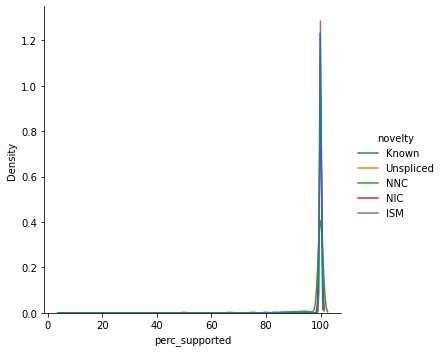

In [56]:
ax = sns.displot(data=ic, x='perc_supported', kind='kde', hue='novelty', common_norm=False)

In [57]:
# percent of ics w/ 100% support per novelty category
ic['fully_supported'] = False
ic.loc[ic.perc_supported==100, 'fully_supported'] = True
ic.tail()

,Chromosome,Strand,Coordinates,Name,source,novelty,gene_id,ic,n_sjs,n_sjs_supported,perc_supported,fully_supported
300045,chrY,+,14522941-14622008-14622591-14723116-14723269-1...,ENSG00000165246_12,lapa,NIC,ENSG00000165246,12,5.0,5.0,100.0,True
300046,chrY,+,2935446-2961073-2961646-2975094-2975244-297551...,ENSG00000067646_8,lapa,NIC,ENSG00000067646,8,6.0,6.0,100.0,True
300047,chrY,+,5000605-5002687,ENSG00000099715_8,lapa,ISM,ENSG00000099715,8,1.0,1.0,100.0,True
300048,chrY,-,13479513-13479317-13479253-13470229-13470120-1...,ENSG00000183878_23,lapa,NIC,ENSG00000183878,23,28.0,28.0,100.0,True
300049,chrY,-,19744670-19744553-19744384-19743239-19743161-1...,ENSG00000012817_11,lapa,NNC,ENSG00000012817,11,26.0,26.0,100.0,True


In [58]:
temp = ic[['fully_supported', 'novelty', 'Name']].groupby(['fully_supported', 'novelty']).count().reset_index().rename({'Name': 'n_ic'}, axis=1)
temp2 = ic[['Name', 'novelty']].groupby('novelty').count().reset_index().rename({'Name':'n_total_ic'}, axis=1)

In [59]:
# only fully supported
temp = temp.loc[temp.fully_supported==True]
temp = temp.merge(temp2, how='left', on='novelty')
temp['perc_fully_supported'] = (temp.n_ic/temp.n_total_ic)*100
temp

,fully_supported,novelty,n_ic,n_total_ic,perc_fully_supported
0,True,ISM,11070,11184,98.980687
1,True,Known,74879,82760,90.477284
2,True,NIC,20870,21287,98.041058
3,True,NNC,13646,15381,88.719849


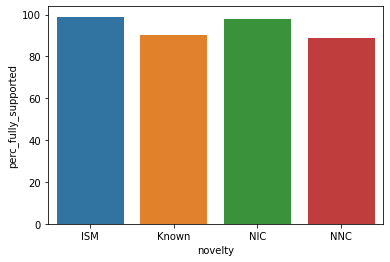

In [60]:
sns.barplot(temp, x='novelty', y='perc_fully_supported')

## what percentage of novel splice junctions from detected ics that we call are supported by intropolis?

In [81]:
len(ic_ids)

132071

In [101]:
df.head()

,Chromosome,Strand,gene_id,Start,End,source,novelty,intropolis
0,chr1,+,ENSG00000000460,169662523,169683468,"v40,v29",Known,True
1,chr1,+,ENSG00000000460,169683625,169683755,"v40,v29",Known,True
2,chr1,+,ENSG00000000460,169683932,169783810,"v40,v29",Known,True
3,chr1,+,ENSG00000000460,169783928,169784876,"v40,v29",Known,True
4,chr1,+,ENSG00000000460,169784913,169798856,"v40,v29",Known,True


In [98]:
# # novel sjs from detected ics
# nov_det_sjs = sj_ic_df.loc[(sj_ic_df.novelty=='Novel')&(sj_ic_df.Name.isin(ic_ids))].copy(deep=True)
# nov_det_sjs.head()
# sjs from detected ics
det_sjs = sj_ic_df.loc[sj_ic_df.Name.isin(ic_ids)]

In [100]:
det_sjs.head()

,Chromosome,Strand,gene_id,Name,Start,End,source,novelty
0,chr1,+,ENSG00000156875,ENSG00000156875_1,100038316,100049908,"v40,v29,lapa,gtex",Known
1,chr1,+,ENSG00000156875,ENSG00000156875_1,100050004,100058665,"v40,v29,lapa,gtex",Known
2,chr1,+,ENSG00000156875,ENSG00000156875_1,100058728,100059877,"v40,v29,lapa,gtex",Known
3,chr1,+,ENSG00000156875,ENSG00000156875_1,100060005,100061834,"v40,v29,lapa,gtex",Known
4,chr1,+,ENSG00000156875,ENSG00000156875_1,100061949,100067976,"v40,v29,lapa,gtex",Known


In [103]:
# whether these sjs were detected in intropolis
print(len(det_sjs))
det_sjs = det_sjs.merge(df[['gene_id', 'Chromosome', 'Start', 'End', 'Strand', 'intropolis']], 
                               on=['gene_id', 'Chromosome', 'Start', 'End', 'Strand'],
                               how='left')
print(len(det_sjs))

974927
974927


In [104]:
temp = det_sjs[['intropolis', 'novelty', 'Start']].groupby(['intropolis', 'novelty']).count().reset_index().rename({'Start':'count'}, axis=1)
sns.barplot(data=temp, 
            x='intropolis',
            y='count')

In [105]:
temp

,intropolis,novelty,count
0,False,Known,5788
1,False,Novel,1951
2,True,Known,943314
3,True,Novel,23874
